# Activity Recognition Meeting

# Import packages and set paths

In [15]:
# Importing the Libraries
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, pearsonr, iqr, zscore
from scipy.signal import butter, welch, filtfilt, resample
import time
import re
import copy
# import nolds
from sklearn import preprocessing
import scipy.io # test matlab code

# from PreprocessFunctions import * # functions for unstacked df with raw data
# from PreprocessFcns import *

%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import sklearn.datasets

In [2]:
if platform.system() == 'Windows':
    if platform.release() == '10':
        path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
        folder_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data'
        dict_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
        features_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\FeatureMatrix'

# Functions

In [16]:
# These functions are based on the unstacked activity dictionary dataframe

# import packages
# import pandas as pd

def process_annotations(path):
    """
    Processes raw annotations file to extract start / end timestamps and remove unnecessary data
    Inputs:  path - filepath of the subject folder containing annotations.csv
    Outputs: df - dataframe containing list of activities and their start / end timestamps
    """
    df = pd.read_csv(os.path.join(path, 'annotations.csv'))
    del df['Timestamp (ms)']
    del df['AnnotationId']
    del df['AuthorId']
    
    # subset Activity Recognition data by partially match EventType string
    df = df[df['EventType'].str.match('Activity')]
    del df['EventType']
    df.Value = df.Value.shift(-1)
    df = df.dropna()
    
    # Create Trial column for Value
    sorter = set(df.Value.unique().flatten())
    sorterIndex = dict(zip(sorter, range(len(sorter))))        
    df['Value_Rank'] = df['Value'].map(sorterIndex)
    df['Trial'] = df.groupby('Value')['Start Timestamp (ms)'].rank(ascending=True).astype(int)
    del df['Value_Rank']
    df = df.reset_index(drop=True).set_index('Value')
    
    return df

def extract_data(SubID, path):
    """
    For a given subject, extracts and separates accelerometer, gyroscope, and 
    EMG/ECG data into trials and sensor per activity
    """
    ## This is the annotations.csv dataset cleaned
    ## Used to match timestamp ranges to the accel, gyro, elec data
    timestamps = process_annotations(path)
#    timestamps = fix_errors(SubID, timestamps)
#    timestamps = add_unstruct_data(timestamps)
    
    # Creates list of sensor locations from folders within subject's raw data directory
    locations = [locs for locs in os.listdir(path) if os.path.isdir(os.path.join(path, locs))]
    
    # Creates dictionary of empty dataframes to merge all accelerometer, gyroscope, and EMG/ECG data for each sensor
    accel = {locs: pd.DataFrame() for locs in locations}
    gyro = {locs: pd.DataFrame() for locs in locations}
    elec = {locs: pd.DataFrame() for locs in locations}
    
    # Finds and merges all accelerometer, gyroscope, and EMG/ECG data for each sensor, retains datetime information
    for root, dirs, files in os.walk(path, topdown=True):
        for filenames in files:
            if filenames.endswith('accel.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                accel[location] = accel[location].append(temp_df)

            elif filenames.endswith('gyro.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                gyro[location] = gyro[location].append(temp_df)

            elif filenames.endswith('elec.csv'):
                p = pathlib.Path(os.path.join(root, filenames))
                location = str(p.relative_to(path)).split("\\")[0]
                temp_df = pd.read_csv(p).set_index('Timestamp (ms)')
                elec[location] = elec[location].append(temp_df)
                
    # List based on Value data of Activity Recognition
    complete= list(['LYING','SITTING','STANDING','WALKING','STAIRS DOWN','STAIRS UP'])
    complete_acts = complete
    
    # Complete dictionary of all activities
    act_dict = {acts: pd.DataFrame() for acts in complete_acts}
    
    # Populate dictionary keys per activity with every iteration / trial
    for activities in complete_acts:
        
        startSize = timestamps.loc[activities, 'Start Timestamp (ms)']
        
        if np.size(startSize) == 1:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)']
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)']
        else:
            startTimestamp = timestamps.loc[activities, 'Start Timestamp (ms)'].values
            endTimestamp = timestamps.loc[activities, 'Stop Timestamp (ms)'].values

        # Create trial dictionary with each key containing all sensor data related with each activity's trial
        trial_dict = {trials: pd.DataFrame() for trials in range(0, np.size(startTimestamp))}

        # Populate trial directory keys
        for trials in range(0, np.size(startTimestamp)):

            if np.size(startSize) == 1:
                startTime = startTimestamp
                endTime = endTimestamp
            else:
                startTime = startTimestamp[trials]
                endTime = endTimestamp[trials]

            # Create sensor location dictionary with each key corresponding to sensor locations
            sensor_dict = {locs: pd.DataFrame() for locs in locations}

            # Extract sensor data and populate sensor_dict with sensor data
            for location in locations:

                data = {'accel': pd.DataFrame(), 'gyro': pd.DataFrame(), 'elec': pd.DataFrame()}

                if not accel[location].empty:
                    accelData = accel[location]
                    data['accel'] = accelData[(accelData.index >= startTime) & (accelData.index <= endTime)]  
 
                if not gyro[location].empty:
                    gyroData = gyro[location]
                    data['gyro'] = gyroData[(gyroData.index >= startTime) & (gyroData.index <= endTime)]
                   
                if not elec[location].empty:
                    elecData = elec[location]
                    data['elec'] = elecData[(elecData.index >= startTime) & (elecData.index <= endTime)]
                   
                sensor_dict[location] = data

            trial_dict[trials] = sensor_dict

        act_dict[activities] = trial_dict
    
    return act_dict, timestamps

def extract_date_from_timestamp(timestamp):
    """
    Convert UNIX to Timestamp data type and cleanup timestamp dataframe
    Input: Dataframe with timestamp annotations in UNIX time in milliseconds
    Output: Dataframe with tasks
    """
    timestamp.reset_index(inplace=True)
    timestamp.insert(1,'date',pd.to_datetime(timestamp['Start Timestamp (ms)'], unit='ms'))
    timestamp.drop(timestamp.columns[[2,3]], inplace=True, axis=1)
    # adjust trial number to start from 0
    timestamp.Trial = timestamp.Trial - 1
    # keep date only in date column
    timestamp.date = timestamp.date.dt.date
    # rename columns
    timestamp.rename(index=str, columns={'Value':'task', 'Trial':'trial'}, inplace=True)
    
    return timestamp

def unstack_ar_dictionary(act_dict):
    """Takes a 4-level nested dictionary and unstacks into a activity recognition dataframe."""
    df = pd.DataFrame([(k1, k2, k3, k4, v) for k1, k234v in act_dict.items()
                           for k2, k34v in k234v.items()
                           for k3, k4v in k34v.items()
                           for k4, v in k4v.items()])
    df.columns = ['task','trial','location','sensor','rawdata']
    return df

def onesubject_meta_raw(dictionary_path, annotation_path, subj):
    """
    Combines the metadata and rawdata into a dataframe before filtering and feature extraction.
    The selected subject's pickle file containing nested dictionary of raw AR data is loaded.
    The dates from the annotation file are added to the final dataframe's metadata.
    
    Functions called:
    process_annotations()
    extract_date_from_timestamp()
    unstack_ar_dictionary()
    
    Input:
    dictionary_path - path that contains the raw data with metadata in nested dictionary format
    annotation_path - path that holds the annotation timestamps that contains the date metadata
    subj - 4 character string ID for subject
    
    Output: Dataframe with metadata (subject, date, test, task, trial, location, sensor)
        and raw data. This dataframe is ready for filtering and feature extraction.
     
    Example: 
    dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
    annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
    subj = 'HC02'
    df = onesubject_meta_raw(dictionary_path, annotation_path, subj)
    """
    # use context manager to reload pickle file
    filename = os.path.join(dictionary_path, subj + 'dict.pkl')
    with open(filename,'rb') as filename:
        act_dict = pickle.load(filename)

    # get timestamp info for feature matrix
    subject_annotation_path = os.path.join(annotation_path, subj)
    timestamp = process_annotations(subject_annotation_path)
    timestamp = extract_date_from_timestamp(timestamp)

    # unstack nested dictionary structure
    df = unstack_ar_dictionary(act_dict)
    # add metadata
    df.insert(0,'subject',subj)
    df.insert(1,'test','activity recognition')
    # merge date data from timestamps
    df = pd.merge(df, timestamp, on=['task','trial'])
    # move date column to 2nd column position
    cols = list(df)
    cols.insert(1, cols.pop(cols.index('date')))
    df = df.loc[:, cols]
    
    return df

def power_spectra_welch_axis(rawdata,fm,fM):
    """Compute PSD on each axis then combine into a dataframe"""
    x = rawdata.iloc[:,0]
    y = rawdata.iloc[:,1]
    z = rawdata.iloc[:,2]
    # number of samples in clip
    n = len(x)
    # sampling rate in clip
    Fs = np.mean(1/(np.diff(x.index)/1000))
    
    # adjusted params to match frequency using scipy.welch with matlab.pwelch
#     fx,Pxx_denX = welch(x,fs=30,nperseg=256,detrend=False)
#     fy,Pxx_denY = welch(y,fs=30,nperseg=256,detrend=False)
#     fz,Pxx_denZ = welch(z,fs=30,nperseg=256,detrend=False)
    # added param: detrend=False
    fx,Pxx_denX = welch(x,Fs,nperseg=min(256,n),detrend=False)
    fy,Pxx_denY = welch(y,Fs,nperseg=min(256,n),detrend=False)
    fz,Pxx_denZ = welch(z,Fs,nperseg=min(256,n),detrend=False)
    
    #return PSD in desired interval of freq
    inds = (fx<=fM)&(fx>=fm)
    f=fx[inds]
    Pxx_denX=Pxx_denX[inds]
    Pxx_denY=Pxx_denY[inds]
    Pxx_denZ=Pxx_denZ[inds]
    Pxx_den = {'PSD_X':Pxx_denX,'PSD_Y':Pxx_denY,'PSD_Z':Pxx_denY}
    Pxxdf = pd.DataFrame(data=Pxx_den,index=f)

    return Pxxdf

def HPfilter_testclip(clip_data,cutoff=0.75,ftype='highpass'):
    """
    Highpass (or lowpass) filter data. HP to remove gravity (offset - limb orientation) from accelerometer 
    data from each visit (trial)
    
    Input: Activity dictionary, cutoff freq [Hz], task, sensor location and type of filter 
    (highpass or lowpass).
    """
    rawdata = clip_data
#     if rawdata.empty is True: #skip if no data for current sensor
#         continue
    idx = rawdata.index
    idx = idx-idx[0]
    rawdata.index = idx
    x = rawdata.values
    Fs = np.mean(1/(np.diff(rawdata.index)/1000)) #sampling rate
    #filter design
    cutoff_norm = cutoff/(0.5*Fs)
#     b,a = butter(4,cutoff_norm,btype=ftype,analog=False)
# Matlab: change params to N=2, cutoff_norm= (prev 0.046875, cutoff=0.75)
    b,a = butter(2,cutoff_norm,btype=ftype,analog=False)
    #filter data
    xfilt = filtfilt(b,a,x,axis=0)
    rawdatafilt = pd.DataFrame(data=xfilt,index=rawdata.index,columns=rawdata.columns)
    clip_data = rawdatafilt
    return clip_data

def featuretest(clip_data):
    """
    Extract features from a simple clip of a single trial and sensor
    Input: simple clip without trial or sensor dict keys
    Output: feature matrix from all clips from given subject and scores for each clip
    Column names separate for acc and gyro data.
    """
    
    features_list = ['meanX','meanY','meanZ','rangeX','rangeY','rangeZ','iqrX','iqrY','iqrZ',
                     'stddev_X','stddev_Y','stddev_Z','skewX','skewY','skewZ','kurtX','kurtY','kurtZ',
                     'hist1_X','hist2_X','hist3_X','hist4_X',
                     'hist1_Y','hist2_Y','hist3_Y','hist4_Y',
                     'hist1_Z','hist2_Z','hist3_Z','hist4_Z',
                     #Moments of derivative: mean, SD, skew, kurtosis
                     'mean_derivative_x','mean_derivative_y','mean_derivative_z',
                     'std_derivative_x','std_derivative_y','std_derivative_z',
                     'skew_derivative_x','skew_derivative_y','skew_derivative_z',
                     'kurt_derivative_x','kurt_derivative_y','kurt_derivative_z',
                     'mean_squared_norm','sum_stddev',
                     'xcorr_XY','xcorr_XZ','xcorr_YZ',
                     'crossprod_raw_xy','crossprod_raw_xz','crossprod_raw_yz',
                     'crossprod_norm_xy','crossprod_norm_xz','crossprod_norm_yz',
                     'abs_crossprod_raw_xy','abs_crossprod_raw_xz','abs_crossprod_raw_yz',
                     'abs_crossprod_norm_xy','abs_crossprod_norm_xz','abs_crossprod_norm_yz',
                     'PSD_mean_X','PSD_mean_Y','PSD_mean_Z',
                     'PSD_std_X','PSD_std_Y','PSD_std_Z',
                     'PSD_skew_X','PSD_skew_Y','PSD_skew_Z',
                     'PSD_kur_X','PSD_kur_Y','PSD_kur_Z',
                     # mean power 20 bins
                     # x axis
                     'meanpower_bin1_x','meanpower_bin2_x','meanpower_bin3_x','meanpower_bin4_x',
                     'meanpower_bin5_x','meanpower_bin6_x','meanpower_bin7_x','meanpower_bin8_x',
                     'meanpower_bin9_x','meanpower_bin10_x','meanpower_bin11_x','meanpower_bin12_x',
                     'meanpower_bin13_x','meanpower_bin14_x','meanpower_bin15_x','meanpower_bin16_x',
                     'meanpower_bin17_x','meanpower_bin18_x','meanpower_bin19_x','meanpower_bin20_x',
                     # y axis
                     'meanpower_bin1_y','meanpower_bin2_y','meanpower_bin3_y','meanpower_bin4_y',
                     'meanpower_bin5_y','meanpower_bin6_y','meanpower_bin7_y','meanpower_bin8_y',
                     'meanpower_bin9_y','meanpower_bin10_y','meanpower_bin11_y','meanpower_bin12_y',
                     'meanpower_bin13_y','meanpower_bin14_y','meanpower_bin15_y','meanpower_bin16_y',
                     'meanpower_bin17_y','meanpower_bin18_y','meanpower_bin19_y','meanpower_bin20_y',
                     # z axis
                     'meanpower_bin1_z','meanpower_bin2_z','meanpower_bin3_z','meanpower_bin4_z',
                     'meanpower_bin5_z','meanpower_bin6_z','meanpower_bin7_z','meanpower_bin8_z',
                     'meanpower_bin9_z','meanpower_bin10_z','meanpower_bin11_z','meanpower_bin12_z',
                     'meanpower_bin13_z','meanpower_bin14_z','meanpower_bin15_z','meanpower_bin16_z',
                     'meanpower_bin17_z','meanpower_bin18_z','meanpower_bin19_z','meanpower_bin20_z',]

    #cycle through all clips for current trial and save dataframe of features for current trial and sensor
    features = []

    rawdata = clip_data

    #range on each axis
    min_xyz = np.min(rawdata,axis=0)
    max_xyz = np.max(rawdata,axis=0)
    r = np.asarray(max_xyz-min_xyz)

    #Moments on each axis - mean, std dev, skew, kurtosis
    mean = np.asarray(np.mean(rawdata,axis=0))
    # np.std default ddof=0 as default so changed to 1 to match matlab
    std = np.asarray(np.std(rawdata,axis=0, ddof=1))
    sk = skew(rawdata)
    # kurtosis has difference of +3 with matlab feature, thus the offset
    kurt = kurtosis(rawdata)+3

    #Cross-correlation between axes pairs
    xcorr_xy = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,1])[0][1]
    xcorr_xz = np.corrcoef(rawdata.iloc[:,0],rawdata.iloc[:,2])[0][1]
    xcorr_yz = np.corrcoef(rawdata.iloc[:,1],rawdata.iloc[:,2])[0][1]
    xcorr = np.array([xcorr_xy, xcorr_xz, xcorr_yz])

    # interquartile range
    iqrange = iqr(rawdata,axis=0)
    
    # histogram of z-score values
    hist = rawdata-np.mean(rawdata)/np.std(rawdata,ddof=1)
    hist_z_scores_x = np.histogram(hist.iloc[:,0],bins=4, range=(-2,2))
    hist_z_scores_y = np.histogram(hist.iloc[:,1], bins=4, range=(-2,2))
    hist_z_scores_z = np.histogram(hist.iloc[:,2], bins=4, range=(-2,2))
    
    hist_z_scores = np.concatenate((hist_z_scores_x[0], hist_z_scores_y[0], hist_z_scores_z[0]), axis=None)

    # derivative - for 3 axis
    derivative = np.diff(rawdata, axis=0)
    # mean of derivative
    mean_derivative = np.mean(derivative,axis=0)
    # std dev of derivative
    std_derivative = np.std(derivative,axis=0)
    # skewness of derivative
    skew_derivative = skew(derivative,axis=0)
    # kurtosis of derivative
        # added offset +3
    kurt_derivative = kurtosis(derivative,axis=0)+3
    moments_of_derivative = np.concatenate((mean_derivative,std_derivative,skew_derivative,kurt_derivative), axis=None)

    # sum of xyz std dev
    sum_stddev = np.array([np.sum(std)])

    # mean of the squared norm
    mean_squared_norm = np.array([np.mean(np.mean(np.square(rawdata)))])

    # normalize values (divided by acc norm) to get cross products
    # The norm should sum across xyz axis at each instance of time
    normdenominator = np.ones((len(rawdata.columns),1))*np.array(np.sqrt(np.sum(np.square(rawdata),axis=1)))
    norm = rawdata/normdenominator.T
    
    # cross products with raw and norm data
    crossprod_norm_xy = np.nanmean(norm.iloc[:,0]*norm.iloc[:,1])
    crossprod_norm_xz = np.nanmean(norm.iloc[:,0]*norm.iloc[:,2])
    crossprod_norm_yz = np.nanmean(norm.iloc[:,1]*norm.iloc[:,2])
    abs_crossprod_norm_xy = np.abs(crossprod_norm_xy)
    abs_crossprod_norm_xz = np.abs(crossprod_norm_xz)
    abs_crossprod_norm_yz = np.abs(crossprod_norm_yz)
    crossprod_raw_xy = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,1])
    crossprod_raw_xz = np.nanmean(rawdata.iloc[:,0]*rawdata.iloc[:,2])
    crossprod_raw_yz = np.nanmean(rawdata.iloc[:,1]*rawdata.iloc[:,2])
    abs_crossprod_raw_xy = np.abs(crossprod_raw_xy)
    abs_crossprod_raw_xz = np.abs(crossprod_raw_xz)
    abs_crossprod_raw_yz = np.abs(crossprod_raw_yz)
    crossprod = np.array([crossprod_raw_xy, crossprod_raw_xz, crossprod_raw_yz,
                          crossprod_norm_xy, crossprod_norm_xz, crossprod_norm_yz,
                          abs_crossprod_raw_xy, abs_crossprod_raw_xz, abs_crossprod_raw_yz,
                          abs_crossprod_norm_xy, abs_crossprod_norm_xz, abs_crossprod_norm_yz])
    
    # High pass filter before passing to PSD (to compare with Matlab process)
    rawdata = HPfilter_testclip(rawdata)
    
    # power spectral density (PSD)
# changed fm=0, to fm=1 like Andrew's code
    Pxx = power_spectra_welch_axis(rawdata,fm=0,fM=10)
    #moments of PSD
    Pxx_moments = np.array([np.nanmean(Pxx.iloc[:,0].values),np.nanmean(Pxx.iloc[:,1].values),np.nanmean(Pxx.iloc[:,2].values),
            np.nanstd(Pxx.iloc[:,0].values),np.nanstd(Pxx.iloc[:,1].values),np.nanstd(Pxx.iloc[:,2].values),
            skew(Pxx.iloc[:,0].values),skew(Pxx.iloc[:,1].values),skew(Pxx.iloc[:,2].values),
            kurtosis(Pxx.iloc[:,0].values),kurtosis(Pxx.iloc[:,1].values),kurtosis(Pxx.iloc[:,2].values)])
########################
    # Mean power in 0.5 Hz bins between 0 and 10 Hz (x, y, z)
    binedges = np.arange(0,10.5,0.5)
    powerbin_df = Pxx.groupby(pd.cut(Pxx.index, bins=binedges)).mean().fillna(0)
    powerbinarray = np.concatenate((powerbin_df.iloc[:,0],powerbin_df.iloc[:,1],powerbin_df.iloc[:,2]), axis=None)

#     # Andrew's mean PSD binning code
#     #power spectra averaged within bins
#     fm = 1; fM = 10; nbins = 10 #frequency bins
# # figure x=Pxx ?
#     Fs = np.mean(1/(np.diff(Pxx.index)/1000)) # sampling rate in clip
#     n = Pxx.size
#     timestep = 1/Fs
#     bin1 = int(timestep*n*fm)
#     bin2 = int(timestep*n*fM)
#     bins = np.linspace(bin1,bin2,nbins,dtype=int) #sample indices
#     deltab = int(0.5*np.diff(bins)[0]) #half the size of bin (in samples)
#     Pxxm = []
#     for i in bins:
#         start = int(max(i-deltab,bins[0]))
#         end = int(min(i+deltab,bins[-1]))
#         Pxxm.append(np.mean(Pxx[start:end]))
#     Pxxm = np.asarray(Pxxm)
# #     plt.plot(bins/(timestep*n),Pxxm)
#     powerbinarray = Pxxm
########################################
    #Assemble features in array
    X = np.concatenate((mean,r,iqrange,std,sk,kurt,hist_z_scores,moments_of_derivative,
                        mean_squared_norm,sum_stddev,xcorr,crossprod,Pxx_moments,powerbinarray))
    features.append(X)
    
    F = np.asarray(features) #feature matrix for all clips from current trial

    features = pd.DataFrame(data=F,columns=features_list,dtype='float32')

    return features

def feature_extraction(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMUs,
    filters out accelerometer or gyroscope sensor data from specified locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type -   'accel' for accelerometer sensor data only
                    'both' for accelerometer and gyroscope sensor data
                    Default is 'accel'.
    
    Output:
    df_feature - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    if sensor_type=='accel':
        df_feature = df.loc[df.sensor == sensor_type]
    # else filter accelerometer and gyro data
    else:
        # acc/gyr locations
        locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                     'posterior_forearm_right', 'posterior_forearm_left']
        # subset 5 locations
        df_feature = df[df.location.isin(locations)]
        df_feature = df_feature.loc[df_feature.sensor != 'elec']
        
    # drop empty dataframes by using len=0 condition
    df_feature = df_feature[df_feature.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    df_feature.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(df_feature.rawdata):
        trialfeature = featuretest(val)
        features = features.append(trialfeature, ignore_index=True)
    # concat features to meta/raw data
    df_feature = pd.concat([df_feature,features], axis=1)#, ignore_index=True)
    
    return df_feature

def rearrange_accgyr_features(df):
    """
    This function takes a dataframe with accelerometer and gyroscope features
    on alternating rows, relabels feature names with prefix acc- or gyr- for
    accelerometer or gyroscope data respectively.
    This prepares the feature matrix for scikit-learn modeling.
    
    Input: 
    df - Dataframe with metadata, raw data, and acc/gyr features on alternating rows.
    
    Output:
    feature_matrix - Dataframe with acc and gyr features relabeled and concatenated horizontally.
    """   
    # try separatig acc and gyr df instead
    acc_df = df.loc[df.sensor == 'accel'].copy()
    gyr_df = df.loc[df.sensor == 'gyro'].copy()
  
    # rename feature columns with prefix to specify acc- or gyr- rawdata and features
    new_names_acc = [(i, 'acc-'+i) for i in acc_df.iloc[:, 7:].columns.values]
    acc_df.rename(columns = dict(new_names_acc), inplace=True)
    new_names_gyr = [(i, 'gyr-'+i) for i in gyr_df.iloc[:, 7:].columns.values]
    gyr_df.rename(columns = dict(new_names_gyr), inplace=True)

    # delete sensor column
    acc_df = acc_df.drop('sensor', 1)
    gyr_df = gyr_df.drop('sensor', 1)
    
    # merge acc and gyr features using task, trial, location as keys
    final_df = pd.merge(acc_df, gyr_df, on=['subject','date','test','task','trial','location'])
    
    # move gyr-rawdata column next to acc-rawdata to keep feature matrix to the right side
    colnames = final_df.columns.tolist()
    neworder = colnames[:7] + colnames[138:139] + colnames[7:138] + colnames[139:]
    final_df = final_df[neworder]
    
    return final_df




########################################################## OMIT
########################################################## OMIT
########################################################## OMIT
# OMIT? - incorporate sensor type in feature_extraction()
def feature_extraction_accel(df, sensor_type='accel'):
    """
    This function takes a dataframe with metadata and raw data from IMU,
    filters out accelerometer or gyroscope sensor data from all locations, 
    then extracts 131 features for each trial.
    
    Input: 
    df - Flattened dataframe with task, trial, location, sensor, and IMU raw data
    sensor_type - Specifies 'accel' for accelerometer and 'gyro' for gyroscope sensor type.
        Default is 'accel'.
    
    Output:
    acceldf - Dataframe with metadata, raw data and features
    """
    # filter accelerometer data
    acceldf = df.loc[df.sensor == sensor_type]
    acceldf.reset_index(drop=True, inplace=True)

    # drop empty dataframes by using len=0 condition
    acceldf = acceldf[acceldf.rawdata.map(lambda d: len(d)) > 0]
    # reset index
    acceldf.reset_index(drop=True, inplace=True)

    features = pd.DataFrame()
    for ind, val in enumerate(acceldf.rawdata):
        trialfeature = featuretest(val)
        features = features.append(trialfeature, ignore_index=True)
    # concat features to meta/raw data
    acceldf = pd.concat([acceldf,features], axis=1)#, ignore_index=True)
    
    return acceldf

#################################################
# OMIT? - incorporated into feature_extraction
def subset_5_locations(df):
    """This function takes a df and subsets 5 locations before acc/gyr feature extraction."""
    # acc/gyr locations
    locations = ['sacrum', 'distal_lateral_shank_right', 'distal_lateral_shank_left',
                 'posterior_forearm_right', 'posterior_forearm_left']

    # subset 5 locations
    df = df[df.location.isin(locations)]
    
    # remove elec sensor
    df = df.loc[df.sensor != 'elec']
    
    return df

# Load data

In [ ]:
rawdatapath = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\
controls\HC02\bicep_left\d5la7y40\2017-11-13T19-09-56-198Z'
rawdatapath2 = os.path.join(rawdatapath, 'accel.csv')
rawdataexample = pd.read_csv(rawdatapath2)#, names=colnames, usecols=selectedcol)

In [17]:
dictionary_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\Data_dict'
subj = 'HC02'
annotation_path = r'//FS2.smpp.local\RTO\Inpatient Sensors -Stroke\Data\biostamp_data\controls'
df = onesubject_meta_raw(dictionary_path, annotation_path, subj)

In [24]:
df.loc[678]

subject                                                  HC02
date                                               2017-11-13
test                                     activity recognition
task                                                  WALKING
trial                                                       0
location                                               sacrum
sensor                                                  accel
rawdata                     Accel X (g)  Accel Y (g)  Acce...
Name: 678, dtype: object

# Raw data example

In [23]:
# Example of raw data from sacrum accelerometer for Walking task, Trial 0
df.rawdata[678].head(5)

,Accel X (g),Accel Y (g),Accel Z (g)
Timestamp (ms),,,
1510606486688,0.010315,0.925002,0.245182
1510606486720,-0.009461,0.990311,0.212833
1510606486752,0.023865,1.028641,0.190494
1510606486784,0.015198,0.983719,0.186587
1510606486816,-0.083314,0.886671,0.190005


# Visualize the signals from the sacrum accelerometer

## 1. Lying

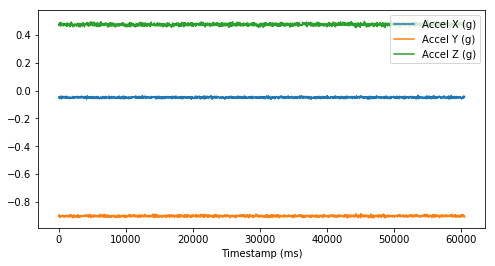

In [37]:
df.rawdata[0].plot(figsize=(8,4))

## 2. Sitting

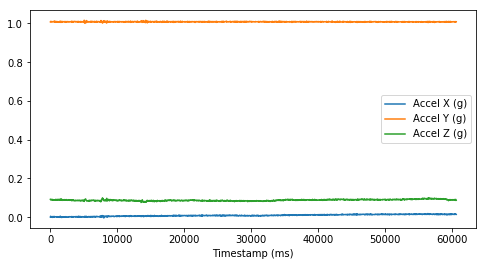

In [38]:
df.rawdata[102].plot(figsize=(8,4))

## 3. Standing

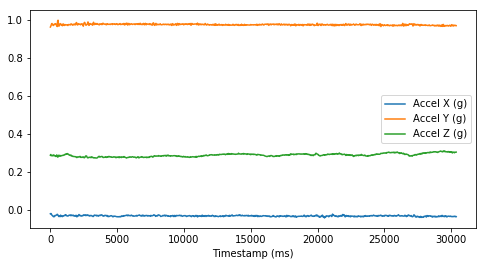

In [39]:
df.rawdata[294].plot(figsize=(8,4))

## 4. Walking

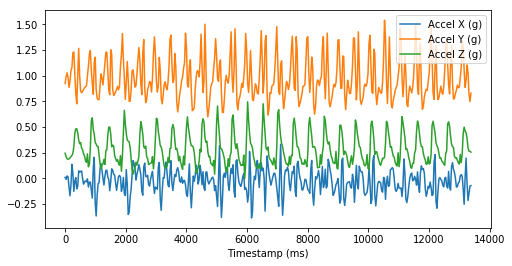

In [35]:
df.rawdata[678].plot(figsize=(8,4))

## 5. Stairs Down

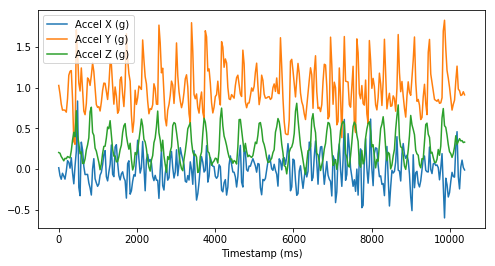

In [40]:
df.rawdata[870].plot(figsize=(8,4))

## 6. Stairs Up

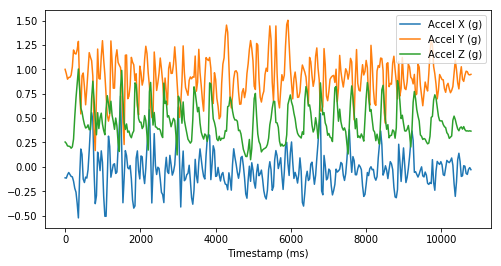

In [41]:
df.rawdata[966].plot(figsize=(8,4))

## Visualize all activity on one plot

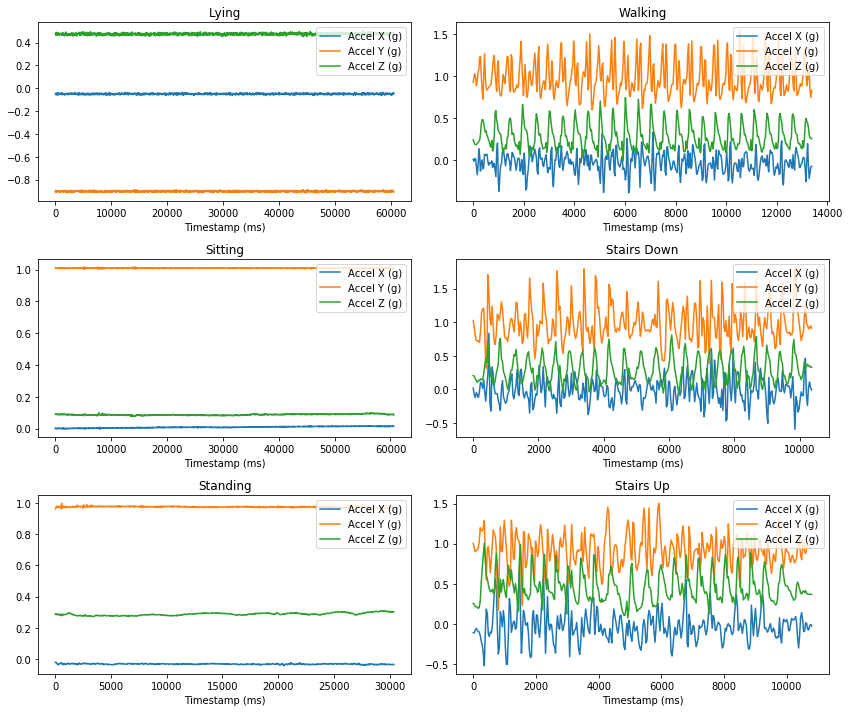

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2)
# dimensions
x, y = 12,10

df.rawdata[0].plot(ax=axes[0,0], figsize=(x,y))
axes[0,0].set_title('Lying')
axes[0,0].legend(loc='upper right')

df.rawdata[102].plot(ax=axes[1,0], figsize=(x,y))
axes[1,0].set_title('Sitting')
axes[1,0].legend(loc='upper right')

df.rawdata[294].plot(ax=axes[2,0], figsize=(x,y))
axes[2,0].set_title('Standing')
axes[2,0].legend(loc='upper right')

df.rawdata[678].plot(ax=axes[0,1], figsize=(x,y))
axes[0,1].set_title('Walking')
axes[0,1].legend(loc='upper right')

df.rawdata[870].plot(ax=axes[1,1], figsize=(x,y))
axes[1,1].set_title('Stairs Down')
axes[1,1].legend(loc='upper right')

df.rawdata[966].plot(ax=axes[2,1], figsize=(x,y))
axes[2,1].set_title('Stairs Up')
axes[2,1].legend(loc='upper right')

plt.tight_layout()
plt.show()

# Cleaned up data

In [25]:
df.loc[df.location=='sacrum'].head(5)

,subject,date,test,task,trial,location,sensor,rawdata
6,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...
7,HC02,2017-11-13,activity recognition,LYING,0,sacrum,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...
8,HC02,2017-11-13,activity recognition,LYING,0,sacrum,elec,Empty DataFrame Columns: [] Index: []
54,HC02,2017-11-13,activity recognition,LYING,1,sacrum,accel,Accel X (g) Accel Y (g) Acce...
55,HC02,2017-11-13,activity recognition,LYING,1,sacrum,gyro,Gyro X (°/s) Gyro Y (°/s) Gy...


# Added Features
- features based on [Megan's JMIR paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5465379/)

In [26]:
# get accelerometer feature matrix from all locations
features_df = feature_extraction(df, 'accel')

In [27]:
features_df.head(5)

,subject,date,test,task,trial,location,sensor,rawdata,meanX,meanY,...,meanpower_bin11_z,meanpower_bin12_z,meanpower_bin13_z,meanpower_bin14_z,meanpower_bin15_z,meanpower_bin16_z,meanpower_bin17_z,meanpower_bin18_z,meanpower_bin19_z,meanpower_bin20_z
0,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_left,accel,Accel X (g) Accel Y (g) Acce...,-0.049779,-0.901753,...,1.521168e-06,1.571855e-06,1.570076e-06,1.759060e-06,1.658028e-06,1.511982e-06,1.167052e-06,1.633379e-06,1.997187e-06,1.479819e-06
1,HC02,2017-11-13,activity recognition,LYING,0,gastrocnemius_right,accel,Accel X (g) Accel Y (g) Acce...,-0.102802,-0.829551,...,1.853239e-06,2.090799e-06,1.601778e-06,1.505428e-06,1.082194e-06,1.385893e-06,1.225574e-06,1.330999e-06,1.440692e-06,1.559841e-06
2,HC02,2017-11-13,activity recognition,LYING,0,sacrum,accel,Accel X (g) Accel Y (g) Acce...,-0.058348,0.183076,...,2.269979e-08,2.174058e-08,2.343769e-08,1.544247e-08,1.614271e-08,1.672363e-08,2.054927e-08,1.836407e-08,1.183496e-08,1.365652e-08
3,HC02,2017-11-13,activity recognition,LYING,0,distal_lateral_shank_right,accel,Accel X (g) Accel Y (g) Acce...,0.105776,0.906628,...,3.367364e-08,2.416130e-08,2.409428e-08,3.310691e-08,3.517773e-08,2.358800e-08,3.311520e-08,2.889551e-08,2.031967e-08,2.555851e-08
4,HC02,2017-11-13,activity recognition,LYING,0,tibialis_anterior_right,accel,Accel X (g) Accel Y (g) Acce...,-0.198152,0.909473,...,1.117714e-06,1.362341e-06,2.060577e-06,2.465715e-06,1.308655e-06,1.561659e-06,1.610429e-06,1.532966e-06,1.301695e-06,1.341989e-06


In [32]:
# features list
features_df.columns.values[8:]

array(['meanX', 'meanY', 'meanZ', 'rangeX', 'rangeY', 'rangeZ', 'iqrX',
       'iqrY', 'iqrZ', 'stddev_X', 'stddev_Y', 'stddev_Z', 'skewX',
       'skewY', 'skewZ', 'kurtX', 'kurtY', 'kurtZ', 'hist1_X', 'hist2_X',
       'hist3_X', 'hist4_X', 'hist1_Y', 'hist2_Y', 'hist3_Y', 'hist4_Y',
       'hist1_Z', 'hist2_Z', 'hist3_Z', 'hist4_Z', 'mean_derivative_x',
       'mean_derivative_y', 'mean_derivative_z', 'std_derivative_x',
       'std_derivative_y', 'std_derivative_z', 'skew_derivative_x',
       'skew_derivative_y', 'skew_derivative_z', 'kurt_derivative_x',
       'kurt_derivative_y', 'kurt_derivative_z', 'mean_squared_norm',
       'sum_stddev', 'xcorr_XY', 'xcorr_XZ', 'xcorr_YZ',
       'crossprod_raw_xy', 'crossprod_raw_xz', 'crossprod_raw_yz',
       'crossprod_norm_xy', 'crossprod_norm_xz', 'crossprod_norm_yz',
       'abs_crossprod_raw_xy', 'abs_crossprod_raw_xz',
       'abs_crossprod_raw_yz', 'abs_crossprod_norm_xy',
       'abs_crossprod_norm_xz', 'abs_crossprod_norm_yz', 'P

# Let's talk about features...
- Sliding windows
- Warping

# Next actions